# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [1]:
%matplotlib inline
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
from astropy.modeling import models, fitting, optimizers, statistic, custom_model
import batman
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler
import corner as triangle
import astropy.constants as c
import astropy.units as u

In [2]:
def Limb_Dark(Teff = 3300,
              Terr = 100,
              log_g = 4.90,
              g_err = 0.2,
              met = 0.0,
              met_err = 0.01,
              filters = [kepler]):
        
    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err],force_download=False)
    
    ps = sc.create_profiles(nsamples=5000)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    return qc,qe

In [3]:
def BATMAN(P,
           Rp,
           t0,
           inc,
           A,
           LD,
           t = None,
           Baseline = 1.0):
                    
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = A                         # semi-major axis (in units of stellar radii)
    params.inc = inc                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    #m = batman.TransitModel(params, t, exp_time=60.0, supersample_factor = 12)   # initializes model
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

In [4]:
def lnprior(LC1,LC2,LC3,LC4,LC5,LC7,LC8,LC9,
            theta,
            planet_a):
    
    A1,A2,A3,A4,A5,A7,A8,A9,B1,B2,B3,B4,B5,B7,B8,B9,t1,t2,t3,t4,t8,rp,a,i = theta
        
    i_min = np.arccos(1/a)*180/np.pi

    if (0.0 <= rp <= 1.0) and (0.5*planet_a <= a <= planet_a + 20) and (i <= 90.0):
        
        return 0.0
    
    return -np.inf

In [5]:
def lnprob(theta,
           LC1,LC2,LC3,LC4,LC5,LC7,LC8,LC9,
           planet_period,
           LD1,LD2,LD3,LD4,LD5,LD7,LD8,LD9,
           airmass1,
           airmass2,
           airmass3,
           airmass4,
           airmass5,
           airmass7,
           airmass8,
           airmass9,
           planet_a,
           plot = False):
        
    # Pull out some model parameters
    A1,A2,A3,A4,A5,A7,A8,A9,B1,B2,B3,B4,B5,B7,B8,B9,t1,t2,t3,t4,t8,rp,a,i = theta     
    
    # First we want a model to perform the lnprob calculation with.
    model1 = (A1 + B1*(airmass1[:-1]-1))*BATMAN(planet_period, rp, t1, i, a, LD1, t = LC1.time)
    model2 = (A2 + B2*(airmass2-1))*BATMAN(planet_period, rp, t2, i, a, LD2, t = LC2.time)
    model3 = (A3 + B3*(airmass3-1))*BATMAN(planet_period, rp, t3, i, a, LD3, t = LC3.time)
    model4 = (A4 + B4*(airmass4-1))*BATMAN(planet_period, rp, t4, i, a, LD4, t = LC4.time)
    model5 = (A5 + B5*(airmass5-1))*BATMAN(planet_period, rp, t4, i, a, LD5, t = LC5.time)
    model7 = (A7 + B7*(airmass7-1))*BATMAN(planet_period, rp, t1, i, a, LD7, t = LC7.time)
    model8 = (A8 + B8*(airmass8-1))*BATMAN(planet_period, rp, t8, i, a, LD8, t = LC8.time)
    model9 = (A9 + B9*(airmass9-1))*BATMAN(planet_period, rp, t8, i, a, LD9, t = LC9.time)
        
    # We need to make sure the uniform priors are accounted for:
    ln_prior = lnprior(LC1,LC2,LC3,LC4,LC5,LC7,LC8,LC9, theta, planet_a)
    
    # This is a Gaussian likelihood, for independent data points
    
    chisq1 = np.sum((LC1.flux - model1)**2/(LC1.flux_err)**2)
    ln_like1 = (np.sum(1/np.sqrt(2*np.pi*(LC1.flux_err))) - 0.5*chisq1)
    
    chisq2 = np.sum((LC2.flux - model2)**2/(LC2.flux_err)**2)
    ln_like2 = (np.sum(1/np.sqrt(2*np.pi*(LC2.flux_err))) - 0.5*chisq2)
    
    chisq3 = np.sum((LC3.flux - model3)**2/(LC3.flux_err)**2)
    ln_like3 = (np.sum(1/np.sqrt(2*np.pi*(LC3.flux_err))) - 0.5*chisq3)
    
    chisq4 = np.sum((LC4.flux - model4)**2/(LC4.flux_err)**2)
    ln_like4 = (np.sum(1/np.sqrt(2*np.pi*(LC4.flux_err))) - 0.5*chisq4)
    
    chisq5 = np.sum((LC5.flux - model5)**2/(LC5.flux_err)**2)
    ln_like5 = (np.sum(1/np.sqrt(2*np.pi*(LC5.flux_err))) - 0.5*chisq5)
    
    chisq7 = np.sum((LC7.flux - model7)**2/(LC7.flux_err)**2)
    ln_like7 = (np.sum(1/np.sqrt(2*np.pi*(LC7.flux_err))) - 0.5*chisq7)
    
    chisq8 = np.sum((LC8.flux - model8)**2/(LC8.flux_err)**2)
    ln_like8 = (np.sum(1/np.sqrt(2*np.pi*(LC8.flux_err))) - 0.5*chisq8)
    
    chisq9 = np.sum((LC9.flux - model9)**2/(LC9.flux_err)**2)
    ln_like9 = (np.sum(1/np.sqrt(2*np.pi*(LC9.flux_err))) - 0.5*chisq9)
    
    return ln_prior+ln_like1+ln_like2+ln_like3+ln_like4+ln_like5+ln_like7+ln_like8+ln_like9

In [6]:
def corner(samples_LCO,samples_TESS):
        
    labels = ['Rp/R*','a/R*','i (deg)']
    Samples_LCO = samples_LCO[-3:].T
    Samples_TESS = samples_TESS[-3:].T
    
    np.random.seed(23)  
    
    figure1 = triangle.corner(Samples_LCO,labels=labels,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},color='red',alpha=1.0,
                            plot_contours=True,zorder=1000,plot_datapoints=False)
    figure1.suptitle("Samples from fitting the TESS data (black) and the LCO data (red)",y=1.04,size=20)
    
    triangle.corner(Samples_TESS,labels=labels,color='black',alpha=0.1,
                     fig=figure1,zorder=-100,plot_contours=True,marker='o',plot_datapoints=False)      
    
    plt.tight_layout()
    plt.savefig('TOI_{:.0f}_Corner.pdf'.format(toi))

In [7]:
def light_curve(lc,
                best_parameters,
                sampler,
                static_params,
                nsteps,
                epoch,
                tic_id,
                obs='first'):
    
    ########################
    # Read in the parameters
    ########################
    
    planet_radius, planet_period, planet_a, planet_i, toi = static_params
    hires_times = np.linspace(lc.time[0]-1,lc.time[-1]+1,1000)
    C1_best, C2_best, rp_best, t_0_best, a_best, i_best = best_parameters
    burnin = int(0.25*nsteps)
    
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,A7_sam,A8_sam,A9_sam,B1_sam,B2_sam,B3_sam,B4_sam,B5_sam,B7_sam,B8_sam,B9_sam,t01_sam,t02_sam,t03_sam,t04_sam,t08_sam,Rp,A,Inc = samples
    
    if obs == 'first':
        C1 = A1_sam
        C2 = B1_sam
        t0 = t01_sam
        airmass = airmass1[:-1]
        offset = offset1
        obs_title = 'LCO-CTIO 2018-11-02 I-band'
        LD = LD1
        observatory = 'LCO'
        
    if obs == 'second':
        C1 = A2_sam
        C2 = B2_sam
        t0 = t02_sam
        airmass = airmass2
        offset = offset2
        obs_title = 'LCO-SAAO 2019-07-10 I-band'
        LD = LD1
        observatory = 'LCO'
        
    if obs == 'third':
        C1 = A3_sam
        C2 = B3_sam
        t0 = t03_sam
        airmass = airmass3
        offset = offset3
        obs_title = 'LCO-CTIO 2019-08-04 V-band'
        LD = LD3
        observatory = 'LCO'
        
    if obs == 'fourth':
        C1 = A4_sam
        C2 = B4_sam
        t0 = t04_sam
        airmass = airmass4
        offset = offset4
        obs_title = 'LCO-SSO 2018-09-18 r\'-band'
        LD = LD4
        observatory = 'LCO'
        
    if obs == 'fifth':
        C1 = A5_sam
        C2 = B5_sam
        t0 = t04_sam
        airmass = airmass5
        offset = offset4
        obs_title = 'LCO-SSO 2018-09-18 i\'-band'
        LD = LD5
        observatory = 'LCO'
        
    if obs == 'seventh':
        C1 = A7_sam
        C2 = B7_sam
        t0 = t01_sam
        airmass = airmass7
        offset = offset7
        obs_title = 'TRAPPIST-South 2018-11-02 I&z-bands'
        LD = LD7
        observatory = 'TRAPPIST-South'
        
    if obs == 'eighth':
        C1 = A8_sam
        C2 = B8_sam
        t0 = t08_sam
        airmass = airmass8
        offset = offset8
        obs_title = 'LCO-CTIO 2019-07-25 g\'-band'
        LD = LD8
        observatory = 'LCO'
        
    if obs == 'nineth':
        C1 = A9_sam
        C2 = B9_sam
        t0 = t08_sam
        airmass = airmass9
        offset = offset8
        obs_title = 'LCO-CTIO 2019-07-25 g\'-band'
        LD = LD8
        observatory = 'LCO'
    
    ########################################################################
    # Calculate the model with the best-fit MCMC params, calculate residuals
    ########################################################################
    
    model_to_plot = BATMAN(planet_period, rp_best, t_0_best, i_best, a_best, LD, t = hires_times)
    best_model = (C1_best + C2_best*(airmass-1))*BATMAN(planet_period, rp_best, t_0_best,
                                                        i_best, a_best, LD, t = lc.time)
    residual = (lc.flux-best_model)/lc.flux_err
    
    #########################
    # Plot the best-fit model
    #########################
            
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title('{}'.format(obs_title),fontsize=20)
    a0.errorbar((lc.time-t_0_best)*24,lc.flux/(C1_best + C2_best*(airmass-1)),
                yerr=lc.flux_err/(C1_best + C2_best*(airmass-1)),
                fmt='o',alpha=0.5,color='royalblue',markersize='5',
                label=observatory+' data')
    a0.plot((hires_times-t_0_best)*24,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Normalized Flux',fontsize=18)
    a0.set_xlim(-2.5,2.5)
    a0.set_ylim(0.985,1.01)
    a0.minorticks_on()
    a0.legend(loc='lower right')
    a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    #########################################
    # Plot 200 random models from the samples
    #########################################
    
    for j in range(0,200,1):
        i = np.random.randint(low=0,high=(nsteps-burnin)*nwalkers)
        sigma_model = BATMAN(P = planet_period, Rp = Rp[i], t0 = t0[i],
                             inc = Inc[i], A = A[i], LD = LD, t = hires_times)
        a0.plot((hires_times-t_0_best)*24,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000,label='Random Samples')
        
    ####################
    # Plot the residuals
    ####################

    a1.scatter((lc.time-t_0_best)*24,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.minorticks_on()
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.set_xlabel('Time from Mid-Transit (hr)')
    a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
        
    plt.savefig('TOI_{:.0f}_modeled'.format(toi)+obs+'.pdf')

In [8]:
params = pandas.read_csv('TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']

In [9]:
index = int(171)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'LCO 1-m'
print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 231702397
TOI 122.01


In [10]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
epoch = Epoch + 2457000.0
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun
star_mass = params['M_s'][index]

Need to download 11 files, approximately 3.67 MB



[[0.25577949 0.25655812]] [[0.00462227 0.00981305]]
Anticipated mid-transit time = 0.603570


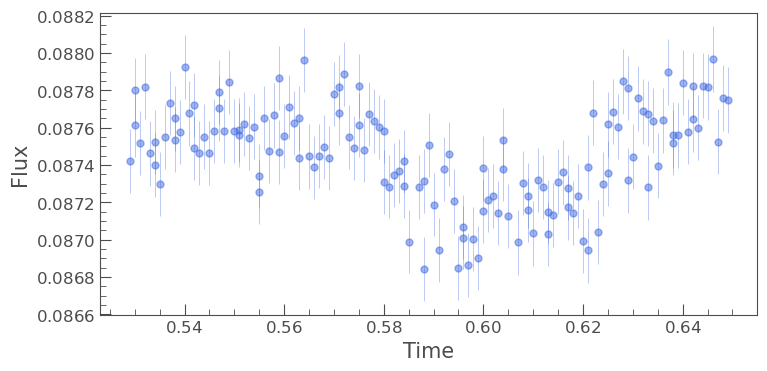

In [13]:
data1 = pandas.read_csv('TOI_122/TIC_231702397_Data2.csv')
flux1 = np.array(data1['rel_flux_T1'])
error1 = np.array(data1['rel_flux_err_T1'])*1.19
times1 = np.array(data1['BJD-OBS'])
airmass1 = np.array(data1['AIRMASS'])
exptime_s1 = np.median(data1['EXPTIME'])
exptime_d1 = exptime_s1 * (1/60) * (1/60) * (1/24)
offset1 = int(times1[0])
times1 = times1-offset1

LC1 = LightCurve(time = times1, flux = flux1, flux_err = error1).remove_outliers(sigma=8)
A1 = np.median(LC1.flux)
B1 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                                     filters=[BoxcarFilter('I',650,1050)])
LD1 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset1
for i in range(len(n)):
    if (mid_transit_times[i] >= LC1.time[0]):
        if (mid_transit_times[i] <= LC1.time[-1]):
            
            expected_t0_1 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_1))

LC1.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

Anticipated mid-transit time = 0.427040


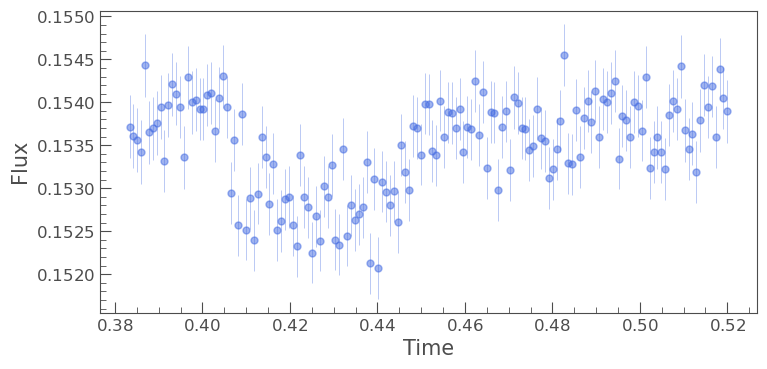

In [14]:
data2 = pandas.read_csv('TOI_122/TIC_231702397_Data3.csv')
flux2 = np.array(data2['rel_flux_T1'])
error2 = np.array(data2['rel_flux_err_T1'])*1.35
times2 = np.array(data2['BJD-OBS'])
airmass2 = np.array(data2['AIRMASS'])
exptime_s2 = np.median(data2['EXPTIME'])
exptime_d2 = exptime_s2 * (1/60) * (1/60) * (1/24)
offset2 = int(times2[0])
times2 = times2-offset2

LC2 = LightCurve(time = times2, flux = flux2, flux_err = error2).remove_outliers(sigma=8)
LC2.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A2 = np.median(LC2.flux)
B2 = 0.0

LD2 = LD1

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset2
for i in range(len(n)):
    if (mid_transit_times[i] >= LC2.time[0]):
        if (mid_transit_times[i] <= LC2.time[-1]):
            
            expected_t0_2 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_2))

[[0.52664634 0.29339892]] [[0.01510278 0.02400864]]
Anticipated mid-transit time = 0.817190


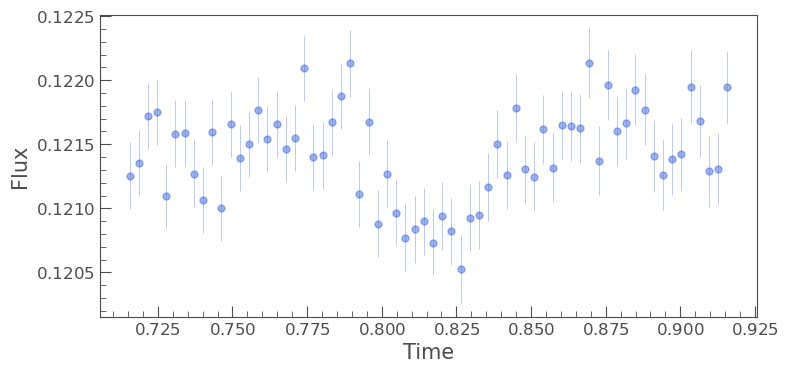

In [15]:
data3 = pandas.read_csv('TOI_122/TIC_231702397_Data5.csv')
flux3 = np.array(data3['rel_flux_T1'])
error3 = np.array(data3['rel_flux_err_T1'])*1.12
times3 = np.array(data3['BJD_TDB'])
airmass3 = np.array(data3['AIRMASS'])
exptime_s3 = np.median(data3['EXPTIME'])
exptime_d3 = exptime_s3 * (1/60) * (1/60) * (1/24)
offset3 = int(times3[0])
times3 = times3-offset3

LC3 = LightCurve(time = times3, flux = flux3, flux_err = error3).remove_outliers(sigma=8)
LC3.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A3 = np.median(LC3.flux)
B3 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('V',480,580)])
LD3 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)
    
n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset3
for i in range(len(n)):
    if (mid_transit_times[i] >= LC3.time[0]):
        if (mid_transit_times[i] <= LC3.time[-1]):
            
            expected_t0_3 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_3))

[[0.52088071 0.26438427]] [[0.01488006 0.02340849]]
Anticipated mid-transit time = 0.901300


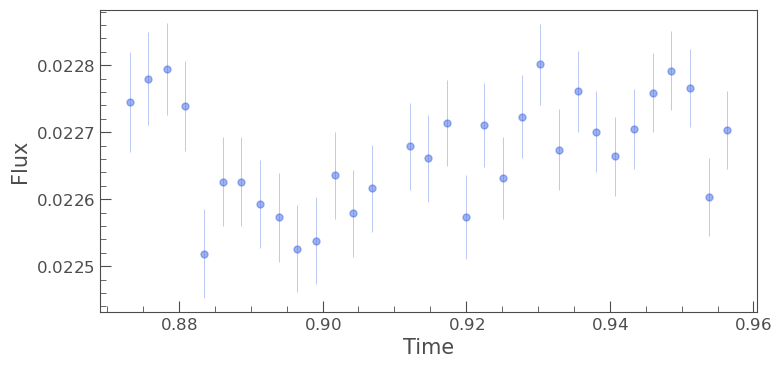

In [16]:
data4 = pandas.read_csv('TOI_122/TOI122_20180918_LCO_rp.csv')
flux4 = np.array(data4['rel_flux_T1'])
error4 = np.array(data4['rel_flux_err_T1'])*1.14
times4 = np.array(data4['BJD_TDB'])
airmass4 = np.array(data4['AIRMASS'])
exptime_s4 = np.median(data4['EXPTIME'])
exptime_d4 = exptime_s4 * (1/60) * (1/60) * (1/24)
offset4 = int(times4[0])
times4 = times4-offset4

LC4 = LightCurve(time = times4, flux = flux4, flux_err = error4).remove_outliers(sigma=8)
LC4.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A4 = np.median(LC4.flux)
B4 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('rp',570,690)])
LD4 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset4
for i in range(len(n)):
    if (mid_transit_times[i] >= LC4.time[0]):
        if (mid_transit_times[i] <= LC4.time[-1]):
            
            expected_t0_4 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_4))

[[0.3049693  0.28981361]] [[0.00685843 0.01393544]]


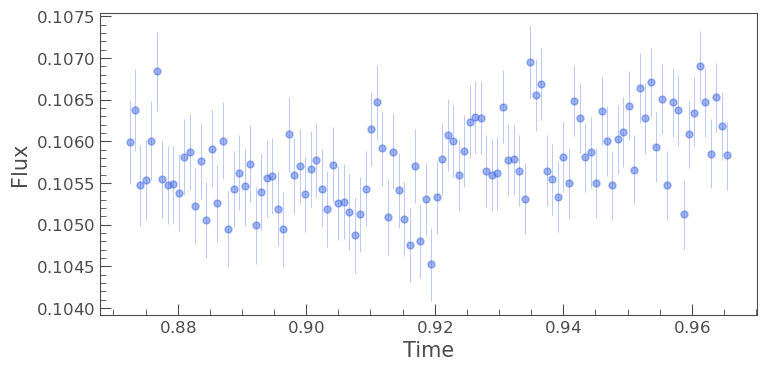

In [17]:
data5 = pandas.read_csv('TOI_122/TOI122_20180918_LCO-SS-1m_ip.csv')
flux5 = np.array(data5['rel_flux_T1'])
error5 = np.array(data5['rel_flux_err_T1'])*1.79
times5 = np.array(data5['BJD_TDB'])
airmass5 = np.array(data5['AIRMASS'])
exptime_s5 = np.median(data5['EXPTIME'])
exptime_d5 = exptime_s5 * (1/60) * (1/60) * (1/24)
offset5 = int(times5[0])
times5 = times5-offset5

LC5 = LightCurve(time = times5, flux = flux5, flux_err = error5).remove_outliers(sigma=8)
LC5.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('ip',640,900)])
LD5 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

A5 = np.median(LC5.flux)
B5 = 0.0

expected_t0_5 = expected_t0_4

In [18]:
# data6 = pandas.read_csv('/Users/willwaalkes/Desktop/TOI_122/TOI122_20180918_SSO_Clear.csv')
# flux6 = np.array(data6['rel_flux_T1'])
# error6 = np.array(data6['rel_flux_err_T1'])
# times6 = np.array(data6['BJD_TDB'])
# airmass6 = np.array(data6['AIRMASS'])
# exptime_s6 = np.median(data6['EXPTIME'])
# exptime_d6 = exptime_s6 * (1/60) * (1/60) * (1/24)
# offset6 = int(times6[0])
# times6 = times6-offset6

# LC6 = LightCurve(time = times6, flux = flux6, flux_err = error6).remove_outliers(sigma=8)
# LC6.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

# A6 = np.median(LC6.flux)
# B6 = 0.0

# n = np.linspace(0,999,1000)
# mid_transit_times = (planet_period*n + epoch)-offset6
# for i in range(len(n)):
#     if (mid_transit_times[i] >= LC6.time[0]):
#         if (mid_transit_times[i] <= LC6.time[-1]):
            
#             expected_t0_6 = mid_transit_times[i]
#             print("Anticipated mid-transit time = {:.6f}".format(expected_t0_6))

[[0.27682922 0.29179895]] [[0.00670061 0.0140416 ]]


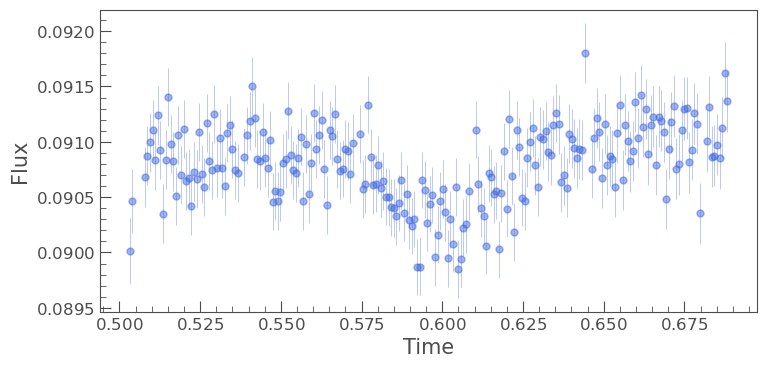

In [19]:
data7 = pandas.read_csv('TOI_122/TOI122_20181102_Trappist-South_I+z.csv')
flux7 = np.array(data7['rel_flux_T1'])
error7 = np.array(data7['rel_flux_err_T1'])*1.33
times7 = np.array(data7['BJD_TDB'])
airmass7 = np.array(data7['AIRMASS'])
exptime_s7 = np.median(data7['EXPTIME'])
exptime_d7 = exptime_s7 * (1/60) * (1/60) * (1/24)
offset7 = int(times7[0])
times7 = times7-offset7

LC7 = LightCurve(time = times7, flux = flux7, flux_err = error7).remove_outliers(sigma=8)
LC7.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A7 = np.median(LC7.flux)
B7 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('I&z',710,900)])
LD7 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

expected_t0_7 = expected_t0_1

[[0.5160566  0.29977016]] [[0.01236307 0.02003473]]
Anticipated mid-transit time = 0.661130


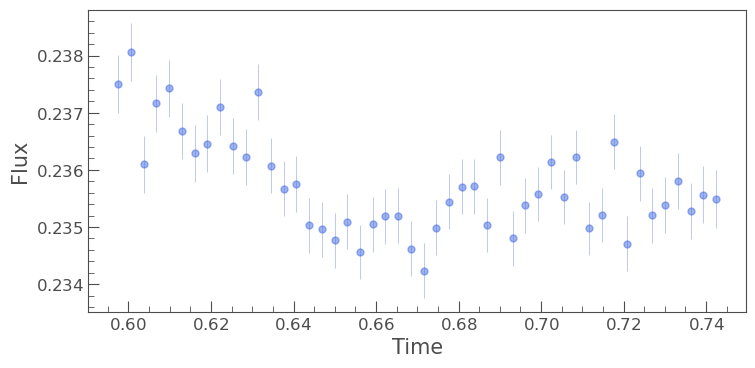

In [20]:
data8 = pandas.read_csv('TOI_122/TOI122_20190725_LCO-CTIO-1m_g.csv')
flux8 = np.array(data8['rel_flux_T1'])
error8 = np.array(data8['rel_flux_err_T1'])*0.77
times8 = np.array(data8['BJD_TDB'])
airmass8 = np.array(data8['AIRMASS'])
exptime_s8 = np.median(data8['EXPTIME'])
exptime_d8 = exptime_s8 * (1/60) * (1/60) * (1/24)
offset8 = int(times8[0])
times8 = times8-offset8

LC8 = LightCurve(time = times8, flux = flux8, flux_err = error8).remove_outliers(sigma=8)
LC8.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A8 = np.median(LC8.flux)
B8 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('gp',400,550)])
LD8 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset8
for i in range(len(n)):
    if (mid_transit_times[i] >= LC8.time[0]):
        if (mid_transit_times[i] <= LC8.time[-1]):
            
            expected_t0_8 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_8))

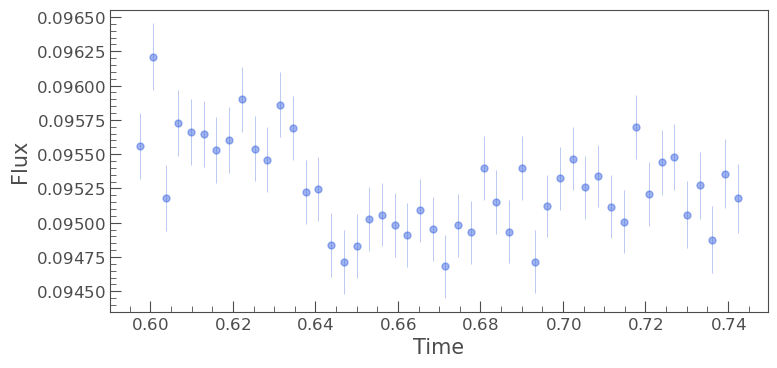

In [21]:
data9 = pandas.read_csv('TOI_122/TOI122_20190725_LCO-CTIO-1m_gp.csv')
flux9 = np.array(data9['rel_flux_T1'])
error9 = np.array(data9['rel_flux_err_T1'])*1.05
times9 = np.array(data9['BJD_TDB'])
airmass9 = np.array(data9['AIRMASS'])
exptime_s9 = np.median(data9['EXPTIME'])
exptime_d9 = exptime_s9 * (1/60) * (1/60) * (1/24)
offset9 = int(times9[0])
times9 = times9-offset9

LC9 = LightCurve(time = times9, flux = flux9, flux_err = error9).remove_outliers(sigma=8)
LC9.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)
LD9 = LD8

A9 = np.median(LC9.flux)
B9 = 0.0

expected_t0_9 = expected_t0_8

In [22]:
# LD1 = [0.2665740324769108, 0.2854557687803473] # I
# LD2 = LD1
# LD3 = [0.5283708982435988, 0.29028041058623677] # V
# LD4 = [0.5213647540339992, 0.2585805917273666] # r'
# LD5 = [0.30821230882663864, 0.32005534556868964] # i'
# LD7 = [0.27183356448871854, 0.3110999447844543] # I & z'
# LD8 = [0.5141717741367481, 0.30245625006329385] # g'
# LD9 = LD8

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [23]:
# intialize some walkers
ndim, nwalkers, nsteps = 24, 150, 120000
burnin = int(0.20*nsteps)

# these are initial parameters
A1_init = np.random.uniform(A1-0.005, A1+0.005, nwalkers)
A2_init = np.random.uniform(A2-0.005, A2+0.005, nwalkers)
A3_init = np.random.uniform(A3-0.005, A3+0.005, nwalkers)
A4_init = np.random.uniform(A4-0.005, A4+0.005, nwalkers)
A5_init = np.random.uniform(A5-0.005, A5+0.005, nwalkers)
#A6_init = np.random.uniform(A6-0.005, A6+0.005, nwalkers)
A7_init = np.random.uniform(A7-0.005, A7+0.005, nwalkers)
A8_init = np.random.uniform(A8-0.005, A8+0.005, nwalkers)
A9_init = np.random.uniform(A9-0.005, A9+0.005, nwalkers)

B1_init = np.random.uniform(0.00, 0.00003, nwalkers)
B2_init = np.random.uniform(0.00, 0.00003, nwalkers)
B3_init = np.random.uniform(0.00, 0.00003, nwalkers)
B4_init = np.random.uniform(0.00, 0.00003, nwalkers)
B5_init = np.random.uniform(0.00, 0.00003, nwalkers)
#B6_init = np.random.uniform(0.00, 0.00003, nwalkers)
B7_init = np.random.uniform(0.00, 0.00003, nwalkers)
B8_init = np.random.uniform(0.00, 0.00003, nwalkers)
B9_init = np.random.uniform(0.00, 0.00003, nwalkers)

t01_init = np.random.uniform(expected_t0_1-0.0005,expected_t0_1+0.0005, nwalkers)
t02_init = np.random.uniform(expected_t0_2-0.0005,expected_t0_2+0.0005, nwalkers)
t03_init = np.random.uniform(expected_t0_3-0.0005,expected_t0_3+0.0005, nwalkers)
t04_init = np.random.uniform(expected_t0_4-0.0005,expected_t0_4+0.0005, nwalkers)
#t05_init = np.random.uniform(expected_t0_5-0.0005,expected_t0_5+0.0005, nwalkers)
#t06_init = np.random.uniform(expected_t0_6-0.0005,expected_t0_6+0.0005, nwalkers)
#t07_init = np.random.uniform(expected_t0_7-0.0005,expected_t0_7+0.0005, nwalkers)
t08_init = np.random.uniform(expected_t0_8-0.0005,expected_t0_8+0.0005, nwalkers)
#t09_init = np.random.uniform(expected_t0_9-0.0005,expected_t0_9+0.0005, nwalkers)

Rp_init = np.random.uniform(planet_radius-0.01, planet_radius+0.01, nwalkers)
a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

p0 = np.transpose([A1_init,A2_init,A3_init,A4_init,A5_init,A7_init,A8_init,A9_init,
                   B1_init,B2_init,B3_init,B4_init,B5_init,B7_init,B8_init,B9_init,
                   t01_init,t02_init,t03_init,t04_init,t08_init,
                   Rp_init, a_init, i_init])

theta = [A1,A2,A3,A4,A5,A7,A8,A9,B1,B2,B3,B4,B5,B7,B8,B9,
         expected_t0_1,expected_t0_2,expected_t0_3,expected_t0_4,
         expected_t0_8,planet_radius,planet_a,planet_i]

In [24]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args = (LC1,LC2,LC3,LC4,LC5,LC7,LC8,LC9,
                                        planet_period,LD1,LD2,LD3,LD4,LD5,LD7,LD8,LD9,
                                        airmass1,airmass2,airmass3,airmass4,
                                        airmass5,airmass7,airmass8,airmass9,
                                        planet_a))
result = sampler.run_mcmc(p0, nsteps)

In [25]:
static_params = planet_radius, planet_period, planet_a, planet_i, toi
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,A7_sam,A8_sam,A9_sam,B1_sam,B2_sam,B3_sam,B4_sam,B5_sam,B7_sam,B8_sam,B9_sam,t01_sam,t02_sam,t03_sam,t04_sam,t08_sam,Rp_sam,A_sam,Inc_sam = samples
np.save('TOI122_LCO_samples.dat',samples)

sig1_A1 = np.percentile(A1_sam, [16., 50., 84.])
sig1_A2 = np.percentile(A2_sam, [16., 50., 84.])
sig1_A3 = np.percentile(A3_sam, [16., 50., 84.])
sig1_A4 = np.percentile(A4_sam, [16., 50., 84.])
sig1_A5 = np.percentile(A5_sam, [16., 50., 84.])
sig1_A7 = np.percentile(A7_sam, [16., 50., 84.])
sig1_A8 = np.percentile(A8_sam, [16., 50., 84.])
sig1_A9 = np.percentile(A9_sam, [16., 50., 84.])
sig1_B1 = np.percentile(B1_sam, [16., 50., 84.])
sig1_B2 = np.percentile(B2_sam, [16., 50., 84.])
sig1_B3 = np.percentile(B3_sam, [16., 50., 84.])
sig1_B4 = np.percentile(B4_sam, [16., 50., 84.])
sig1_B5 = np.percentile(B5_sam, [16., 50., 84.])
sig1_B7 = np.percentile(B7_sam, [16., 50., 84.])
sig1_B8 = np.percentile(B8_sam, [16., 50., 84.])
sig1_B9 = np.percentile(B9_sam, [16., 50., 84.])
sig1_t01 = np.percentile(t01_sam, [16., 50., 84.])
sig1_t02 = np.percentile(t02_sam, [16., 50., 84.])
sig1_t03 = np.percentile(t03_sam, [16., 50., 84.])
sig1_t04 = np.percentile(t04_sam, [16., 50., 84.])
sig1_t08 = np.percentile(t08_sam, [16., 50., 84.])

sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

In [26]:
# for i in range(len(samples)):
#     print(emcee.autocorr.integrated_time(samples[i]))

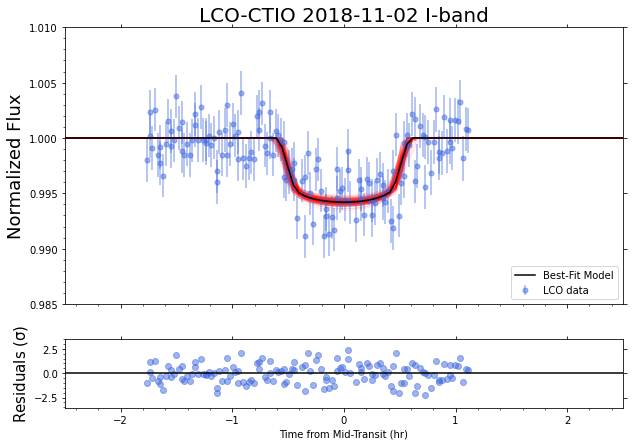

In [27]:
best_parameters = [sig1_A1[1],sig1_B1[1],sig1_Rp[1],sig1_t01[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC1,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='first')

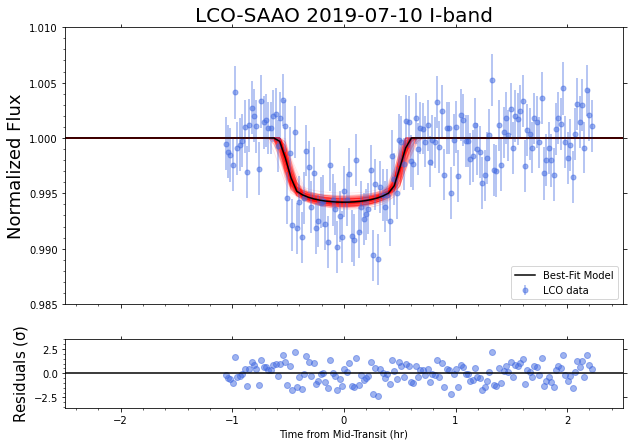

In [28]:
best_parameters = [sig1_A2[1],sig1_B2[1],sig1_Rp[1],sig1_t02[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC2,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='second')

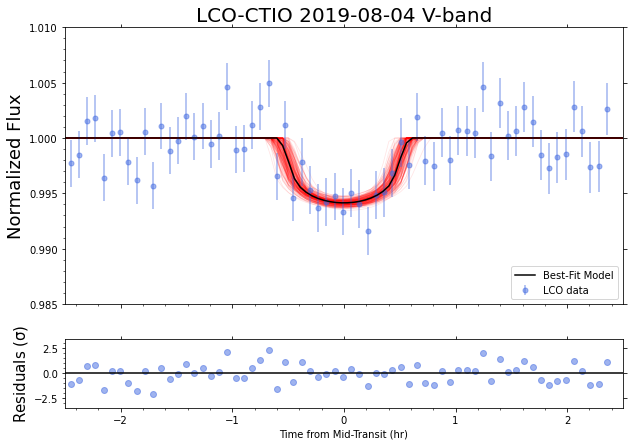

In [29]:
best_parameters = [sig1_A3[1],sig1_B3[1],sig1_Rp[1],sig1_t03[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC3,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='third')

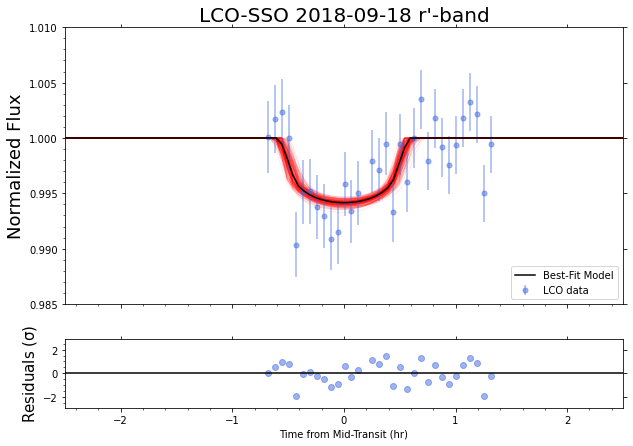

In [30]:
best_parameters = [sig1_A4[1],sig1_B4[1],sig1_Rp[1],sig1_t04[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC4,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='fourth')

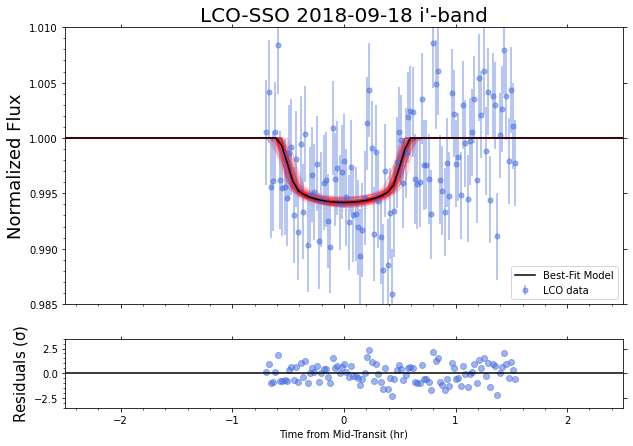

In [31]:
best_parameters = [sig1_A5[1],sig1_B5[1],sig1_Rp[1],sig1_t04[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC5,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='fifth')

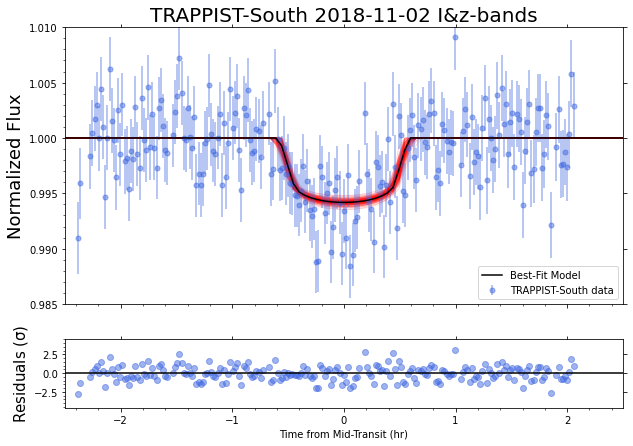

In [32]:
best_parameters = [sig1_A7[1],sig1_B7[1],sig1_Rp[1],sig1_t01[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC7,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='seventh')

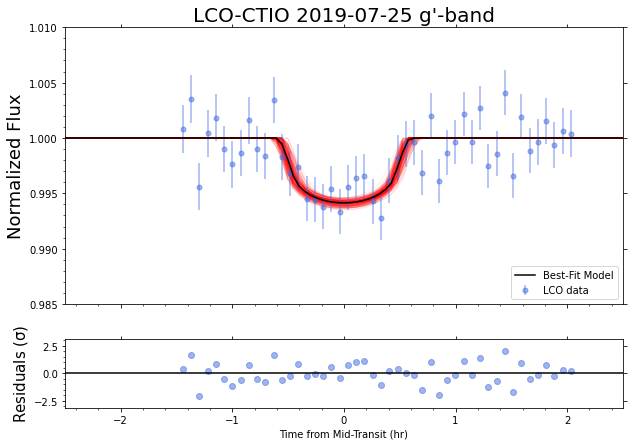

In [33]:
best_parameters = [sig1_A8[1],sig1_B8[1],sig1_Rp[1],sig1_t08[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC8,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='eighth')

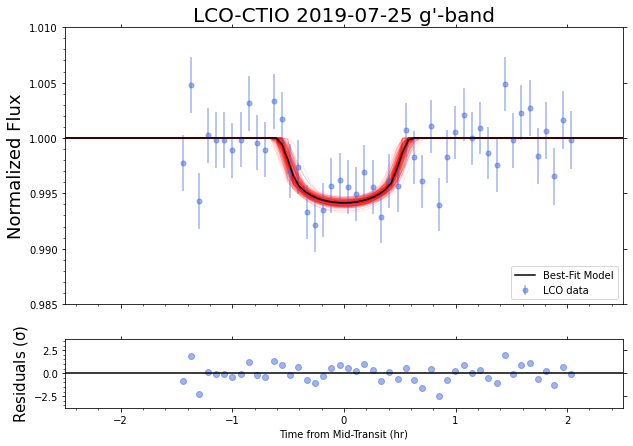

In [34]:
best_parameters = [sig1_A9[1],sig1_B9[1],sig1_Rp[1],sig1_t08[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC9,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='nineth')

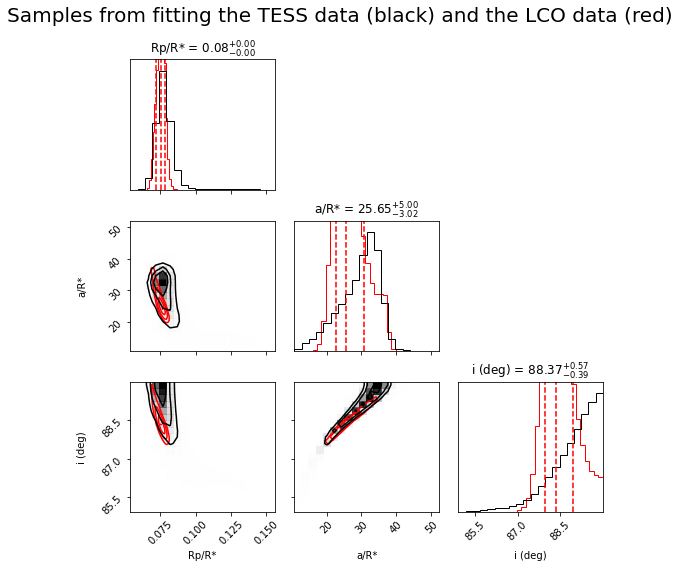

In [35]:
TESS_samples = np.load('TOI_122/TOI122_TESS_samples.dat.npy')
corner(samples,TESS_samples)

In [36]:
print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

b_sam = np.cos((Inc_sam)*np.pi/180)*A_sam

sig1_b = np.percentile(b_sam, [16., 50., 84.])

print('Impact parameter (b) = {:.3f}'.format(sig1_b[1]),
      '+ {:.6f}'.format(sig1_b[2]-sig1_b[1]),
      '- {:.6f}'.format(sig1_b[1]-sig1_b[0]))

print('Mid-Transit Time = {:.6f}'.format(offset1+sig1_t01[1]),
      '+ {:.6f}'.format(sig1_t01[2]-sig1_t01[1]),
      '- {:.6f}'.format(sig1_t01[1]-sig1_t01[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset1+expected_t0_1))

print('Mid-Transit Time = {:.6f}'.format(offset2+sig1_t02[1]),
      '+ {:.6f}'.format(sig1_t02[2]-sig1_t02[1]),
      '- {:.6f}'.format(sig1_t02[1]-sig1_t02[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset2+expected_t0_2))

print('Mid-Transit Time = {:.6f}'.format(offset3+sig1_t03[1]),
      '+ {:.6f}'.format(sig1_t03[2]-sig1_t03[1]),
      '- {:.6f}'.format(sig1_t03[1]-sig1_t03[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset3+expected_t0_3))

print('Mid-Transit Time = {:.6f}'.format(offset4+sig1_t04[1]),
      '+ {:.6f}'.format(sig1_t04[2]-sig1_t04[1]),
      '- {:.6f}'.format(sig1_t04[1]-sig1_t04[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset4+expected_t0_4))

print('Mid-Transit Time = {:.6f}'.format(offset8+sig1_t08[1]),
      '+ {:.6f}'.format(sig1_t08[2]-sig1_t08[1]),
      '- {:.6f}'.format(sig1_t08[1]-sig1_t08[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset8+expected_t0_8))

Rp/R* = 0.0753 + 0.0028 - 0.0033
a/R* = 25.653 + 5.005 - 3.019
Inclination (Deg) = 88.370 + 0.567 - 0.391
Impact parameter (b) = 0.729 + 0.069043 - 0.161239
Mid-Transit Time = 2458425.602555 + 0.000619 - 0.000620
Anticipated mid-transit time = 2458425.603570
Mid-Transit Time = 2458674.427549 + 0.000766 - 0.000747
Anticipated mid-transit time = 2458674.427040
Mid-Transit Time = 2458699.817590 + 0.001878 - 0.001931
Anticipated mid-transit time = 2458699.817190
Mid-Transit Time = 2458379.901499 + 0.001232 - 0.001169
Anticipated mid-transit time = 2458379.901300
Mid-Transit Time = 2458689.657696 + 0.001242 - 0.001136
Anticipated mid-transit time = 2458689.661130


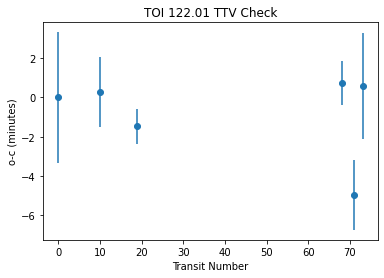

In [37]:
expected = np.array([1329.1215+2457000,
                     expected_t0_1+offset1,
                     expected_t0_2+offset2,
                     expected_t0_3+offset3,
                     expected_t0_4+offset4,
                     expected_t0_8+offset8])
observed = np.array([1329.1215+2457000,
                     sig1_t01[1]+offset1,
                     sig1_t02[1]+offset2,
                     sig1_t03[1]+offset3,
                     sig1_t04[1]+offset4,
                     sig1_t08[1]+offset8])
obs_err = np.array([0.0023,
                    (sig1_t01[2]-sig1_t01[1]),
                    (sig1_t02[2]-sig1_t02[1]),
                    (sig1_t03[2]-sig1_t03[1]),
                    (sig1_t04[2]-sig1_t04[1]),
                    (sig1_t08[2]-sig1_t08[1])])

transit_number = np.array([0,19,68,73,10,71])

diff = (observed-expected)*24.0*60.0
obs_err_plot = obs_err*24.0*60.0

data = Table([transit_number, observed, obs_err],names=['num','t0','t0_err'])
ascii.write(data,'toi_122_ephem.txt',overwrite=True)

plt.figure()
plt.errorbar(transit_number,diff, yerr=obs_err_plot,fmt='o')
plt.ylabel('o-c (minutes)')
plt.xlabel('Transit Number')
plt.title('TOI {} TTV Check'.format(toi))
plt.savefig('TOI_{:.0f}_TTV.pdf'.format(toi))
plt.show()